# Nearest Neighbor item based Collaborative Filtering

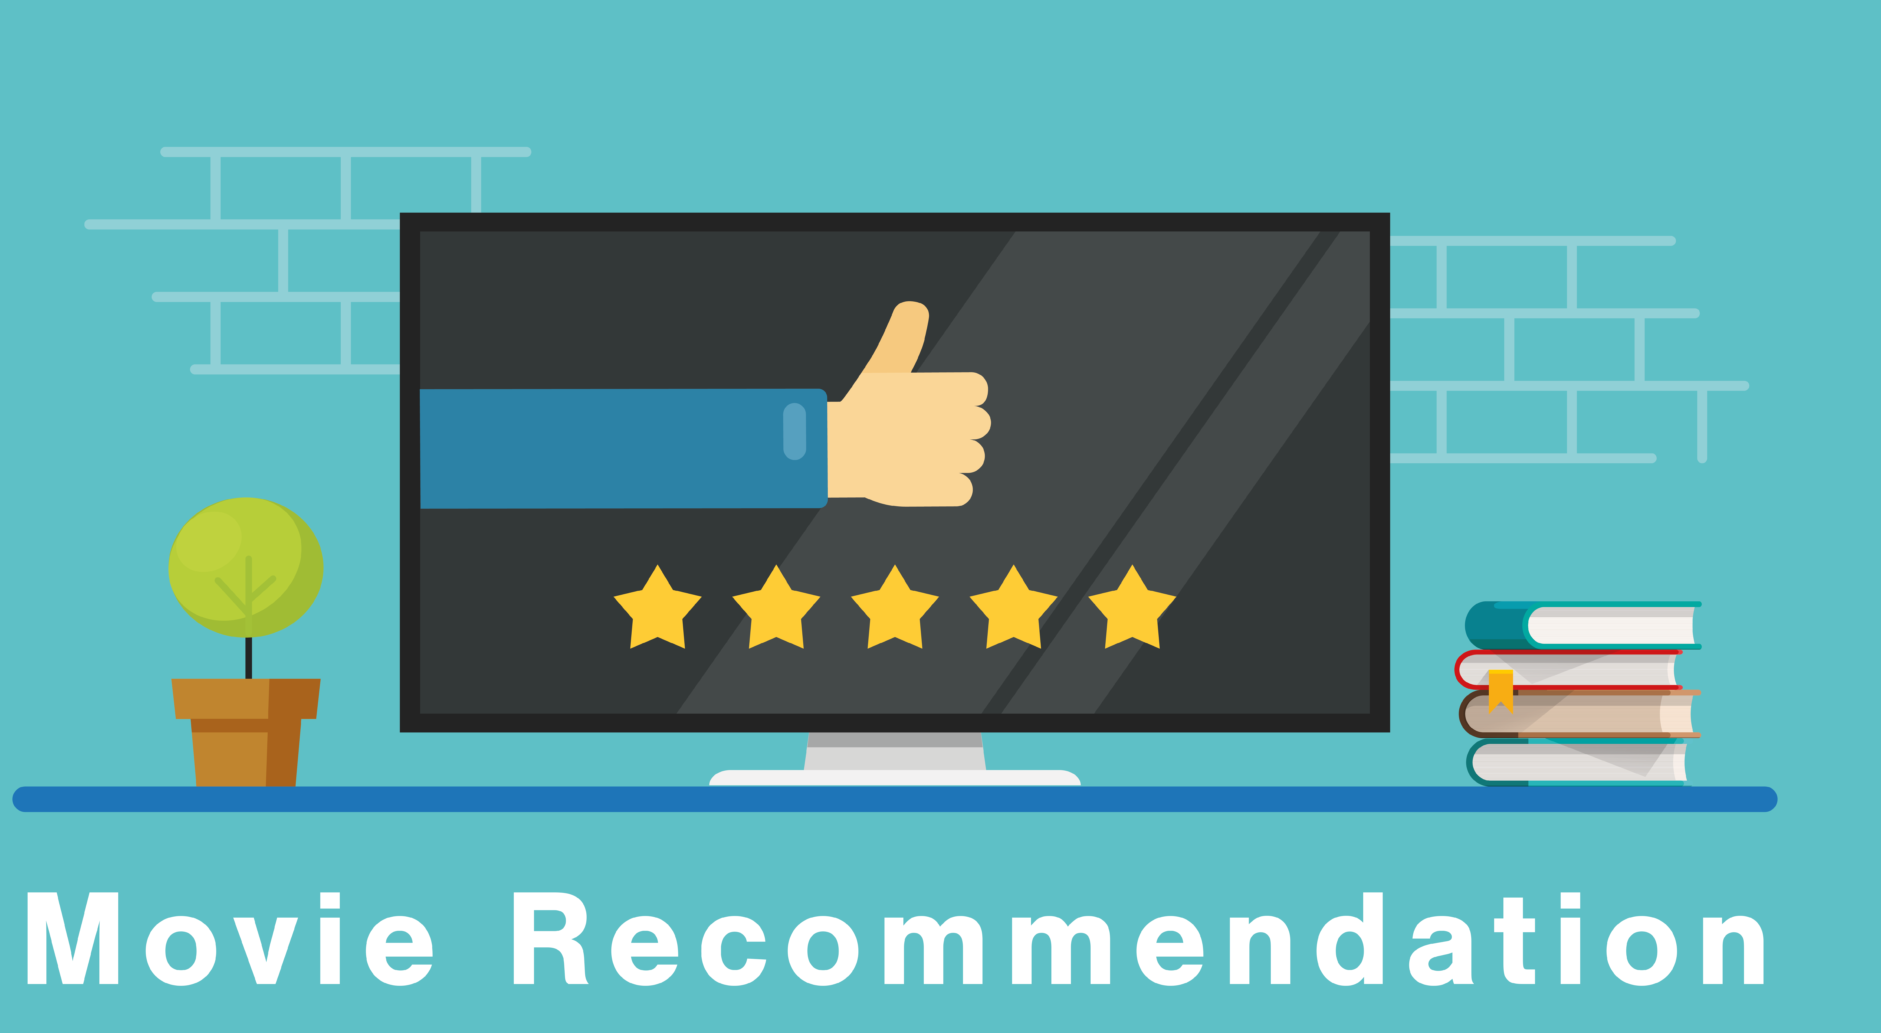

In [2]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [19]:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip

--2021-07-02 14:28:37--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  22.4MB/s    in 0.2s    

2021-07-02 14:28:38 (22.4 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [20]:
!unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


## 1. Load Data

In [34]:
r_cols = ['userId', 'movieId', 'rating']
df_ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, usecols=range(3), encoding="ISO-8859-1",dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [35]:
m_cols = ['movieId', 'title']
df_movies  = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(2), encoding="ISO-8859-1",dtype={'movieId': 'int32', 'title': 'str'})

In [36]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  1682 non-null   int32 
 1   title    1682 non-null   object
dtypes: int32(1), object(1)
memory usage: 19.8+ KB


In [37]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100000 non-null  int32  
 1   movieId  100000 non-null  int32  
 2   rating   100000 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 1.1 MB


In [38]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [39]:
df_ratings.head()

,userId,movieId,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


In [40]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 943 unique users and 1682 unique movies in this data set


## 2. Exploratory data analysis

#### 1. Plot the counts of each rating

In [41]:
# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
1.0,6110
2.0,11370
3.0,27145
4.0,34174
5.0,21201


In [42]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,1486126
1.0,6110
2.0,11370
3.0,27145
4.0,34174
5.0,21201


In [43]:
# add log count
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,1486126,14.211683
1.0,6110,8.717682
2.0,11370,9.338734
3.0,27145,10.208948
4.0,34174,10.439220
5.0,21201,9.961804


Text(0, 0.5, 'number of ratings')

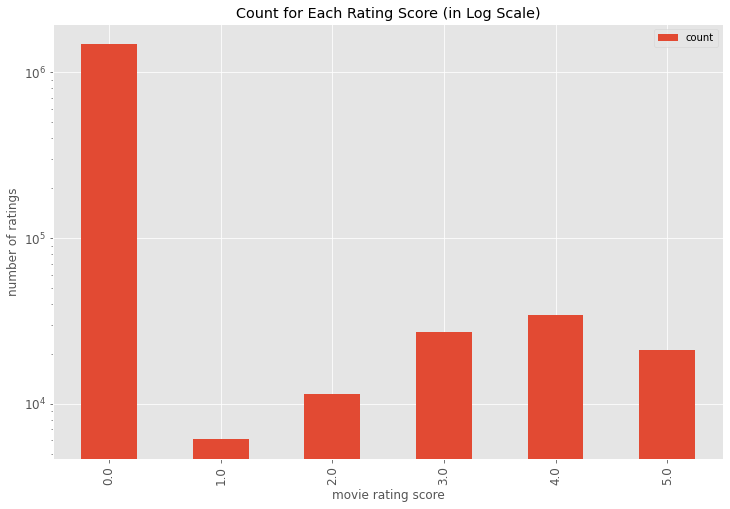

In [44]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

It's interesting that there are more people giving rating score of 3 and 4 than other scores 

#### 2. Plot rating frequency of all movies

In [45]:
df_ratings.head()

,userId,movieId,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


In [46]:
# get rating frequency
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,452
2,131
3,90
4,209
5,86


Text(0, 0.5, 'number of ratings')

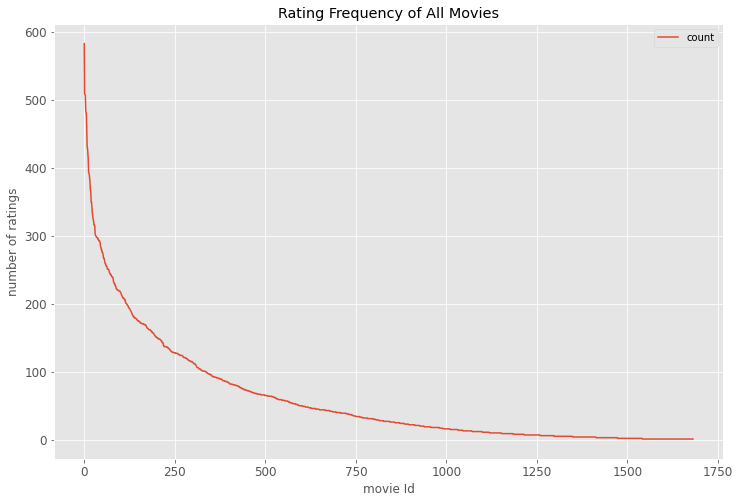

In [47]:
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

Text(0, 0.5, 'number of ratings (log scale)')

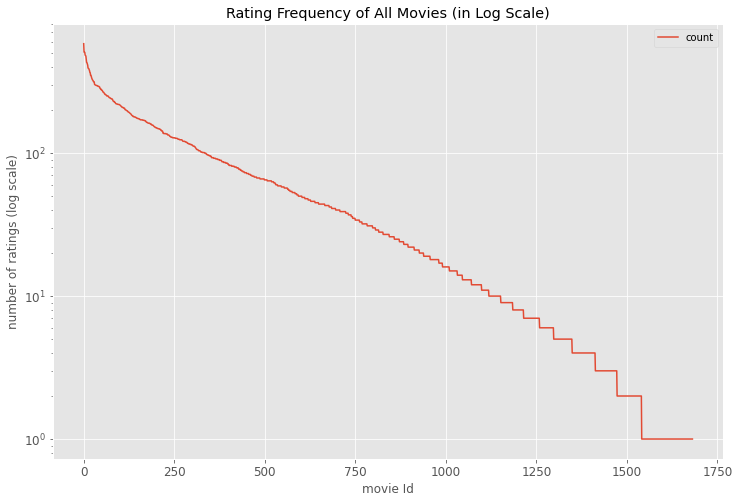

In [48]:
# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

In [49]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    583.00
0.95    229.85
0.90    169.00
0.85    127.85
0.80    100.00
0.75     80.00
0.70     65.00
0.65     51.65
Name: count, dtype: float64

In [50]:
# filter data
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (100000, 3)
shape of ratings data after dropping unpopular movies:  (83715, 3)


In [51]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,233
2,56
3,39
4,19
5,134


Text(0, 0.5, 'number of ratings')

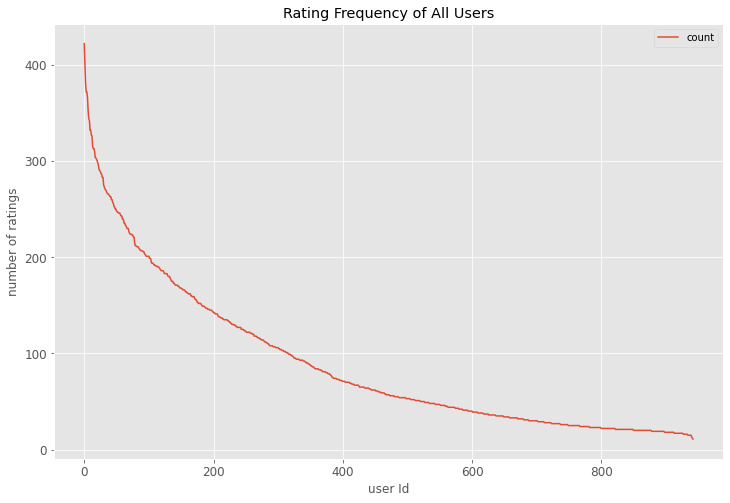

In [52]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [53]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    422.0
0.95    251.8
0.90    202.8
0.85    171.0
0.80    147.0
0.75    128.0
0.70    111.0
0.65     94.0
0.60     79.2
0.55     67.0
Name: count, dtype: float64

In [54]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (100000, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (71687, 3)


## 3. Train KNN model for item-based collaborative filtering
 - Reshaping the Data
 - Fitting the Model

In [55]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = { movie: i for i, movie in enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [56]:
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [60]:
movie_user_mat.shape

(603, 527)

In [61]:
query_index = np.random.choice(movie_user_mat.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(movie_user_mat.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

535


In [63]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(movie_user_mat.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, movie_user_mat.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for 762:

1: 1048, with distance of 0.48389309644699097:
2: 111, with distance of 0.5337021350860596:
3: 237, with distance of 0.5513051748275757:
4: 100, with distance of 0.5561890602111816:
5: 150, with distance of 0.5601362586021423:
